In [1]:
# 패키지 로드
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import os, random

from scipy import sparse
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.nn.init import normal_
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import plotnine
from plotnine import *

In [2]:
# 하이퍼파라미터 
class cfg: 
    gpu_idx = 0
    device = torch.device("cuda:{}".format(gpu_idx) if torch.cuda.is_available() else "cpu")
    top_k = 25 #############
    seed = 42
    neg_ratio = 100 #######
    test_size = 0.2

In [3]:
# 하이퍼 파라미터 설정 
cfg.batch_size = 256
cfg.emb_dim = 256
cfg.layer_dim = 256
cfg.dropout = 0.1
cfg.epochs = 25
cfg.learning_rate = 0.0025
cfg.reg_lambda = 0
cfg.check_epoch = 1

In [4]:
# 시드 고정 
def seed_everything(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
seed_everything(cfg.seed)

In [5]:
# 경로 설정
data_path = './data'
saved_path = './code/saved'
output_path = './code/submission'

In [6]:
history_df = pd.read_csv(os.path.join(data_path, 'history_data.csv'), encoding='utf-8')
profile_df = pd.read_csv(os.path.join(data_path, 'profile_data.csv'), encoding='utf-8')
meta_df = pd.read_csv(os.path.join(data_path, 'meta_data.csv'), encoding='utf-8')
watch_e_df = pd.read_csv(os.path.join(data_path, 'watch_e_data.csv'), encoding='utf-8')
search_df =  pd.read_csv(os.path.join(data_path, 'search_data.csv'), encoding='utf-8')
buy_df = pd.read_csv(os.path.join(data_path, 'buy_data.csv'), encoding='utf-8')
meta_plus_df = pd.read_csv(os.path.join(data_path, 'meta_data_plus.csv'), encoding='utf-8')

In [7]:
# 데이터 전처리 (중복제거) 
# 참고 : drop_duplicates의 subset을 무엇으로 구성하냐에 따라서 제거되는 항목들이 다름 
# ex) 'profile_id', 'album_id' : 중복된 시청이력 모두 제거 / 'profile_id', 'album_id', 'log_time' : 같은 시간에 시청한 이력만 제거 
data = history_df[['profile_id', 'log_time', 'album_id']].drop_duplicates(subset=['profile_id', 'album_id', 'log_time']).sort_values(by = ['profile_id', 'log_time']).reset_index(drop = True)
data['rating'] = 1

cfg.n_users = data.profile_id.max()+1
cfg.n_items = data.album_id.max()+1

In [8]:
# 학습 및 검증 데이터 분리
train, valid = train_test_split(
    data, test_size=cfg.test_size, random_state=cfg.seed,
)
print('학습 데이터 크기:', train.shape)
print('검증 데이터 크기:', valid.shape)

학습 데이터 크기: (719401, 4)
검증 데이터 크기: (179851, 4)


In [32]:
data

,profile_id,log_time,album_id,rating
0,3,20220301115719,15,1
1,3,20220301115809,16,1
2,3,20220301115958,17,1
3,3,20220301120118,18,1
4,3,20220301120229,19,1
...,...,...,...,...
899247,33032,20220427155668,381,1
899248,33032,20220427155680,381,1
899249,33032,20220427155810,125,1
899250,33032,20220427155838,125,1


In [9]:
# Matrix 형태로 변환 
train = train.to_numpy()
matrix = sparse.lil_matrix((cfg.n_users, cfg.n_items))  
for (p, _, i, r) in tqdm(train):
    matrix[p, i] = r
    
train = sparse.csr_matrix(matrix)
train = train.toarray()
print("train 형태: \n", train)

100%|███████████████████████████████| 719401/719401 [00:01<00:00, 361080.28it/s]


train 형태: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
profile_df = profile_df.set_index('profile_id')

In [11]:
le = LabelEncoder()
profile_df['sex'] = le.fit_transform(profile_df['sex'])
profile_df['pr_interest_keyword_cd_1'] = le.fit_transform(profile_df['pr_interest_keyword_cd_1'])
profile_df['pr_interest_keyword_cd_2'] = le.fit_transform(profile_df['pr_interest_keyword_cd_2'])
profile_df['pr_interest_keyword_cd_3'] = le.fit_transform(profile_df['pr_interest_keyword_cd_3'])
profile_df['ch_interest_keyword_cd_1'] = le.fit_transform(profile_df['ch_interest_keyword_cd_1'])
profile_df['ch_interest_keyword_cd_2'] = le.fit_transform(profile_df['ch_interest_keyword_cd_2'])
profile_df['ch_interest_keyword_cd_3'] = le.fit_transform(profile_df['ch_interest_keyword_cd_3'])

In [12]:
# 유저 특징 정보 추출 
user_features = profile_df[['age', 'sex',
                            'pr_interest_keyword_cd_1',
                            'pr_interest_keyword_cd_2',
                            'pr_interest_keyword_cd_3',
                            'ch_interest_keyword_cd_1',
                            'ch_interest_keyword_cd_2',
                            'ch_interest_keyword_cd_3']].to_dict()

In [13]:
cfg.n_pr_interest_keyword = profile_df['pr_interest_keyword_cd_1'].nunique()
cfg.n_ch_interest_keyword = profile_df['ch_interest_keyword_cd_1'].nunique()

In [100]:
cfg.n_pr_interest_keyword

8

In [101]:
cfg.n_ch_interest_keyword

9

In [44]:
user_features

{'age': {3: 5,
  5: 5,
  7: 9,
  12: 6,
  16: 12,
  19: 3,
  20: 7,
  22: 4,
  24: 5,
  26: 7,
  27: 7,
  30: 2,
  31: 6,
  33: 7,
  35: 7,
  55: 8,
  56: 11,
  59: 7,
  62: 5,
  63: 9,
  66: 7,
  68: 5,
  74: 2,
  77: 9,
  80: 7,
  89: 7,
  94: 7,
  96: 3,
  101: 4,
  102: 3,
  103: 7,
  109: 4,
  110: 8,
  115: 4,
  116: 7,
  118: 6,
  121: 6,
  122: 3,
  124: 8,
  127: 7,
  129: 6,
  130: 10,
  136: 2,
  137: 7,
  139: 9,
  144: 2,
  150: 6,
  152: 6,
  156: 4,
  165: 7,
  170: 8,
  172: 7,
  176: 3,
  179: 5,
  181: 5,
  182: 8,
  187: 2,
  192: 5,
  193: 9,
  195: 6,
  198: 8,
  201: 4,
  207: 4,
  209: 6,
  211: 8,
  214: 6,
  220: 8,
  228: 9,
  229: 3,
  230: 2,
  233: 6,
  240: 2,
  248: 5,
  251: 6,
  255: 9,
  258: 10,
  260: 6,
  261: 4,
  264: 4,
  279: 4,
  290: 8,
  292: 2,
  293: 6,
  300: 6,
  302: 6,
  303: 2,
  304: 5,
  307: 3,
  309: 4,
  316: 6,
  317: 5,
  321: 6,
  326: 8,
  327: 4,
  335: 6,
  338: 12,
  345: 7,
  346: 1,
  349: 5,
  350: 1,
  358: 8,
  361: 5,

In [14]:
meta_df = meta_df.set_index('album_id')

In [15]:
meta_df

,title,sub_title,genre_large,genre_mid,genre_small,country,run_time,onair_date,cast_1,cast_2,cast_3,cast_4,cast_5,cast_6,cast_7
album_id,,,,,,,,,,,,,,,
749,어둠이 무서워요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
750,우리는 친구,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2131,타요의 첫 운행,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2625,길 잃은 타요,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
2594,새내기 꼬마 버스의 하루,꼬마버스 타요1,키즈,TV만화,NaN,한국,660,NaN,타요,로기,라니,가니,시투,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39873,로티프렌즈와 색칠놀이! - 그리피 ＆ 사탕 바구니,로티프렌즈 미술놀이,키즈,놀이교실,NaN,한국,477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39874,로티프렌즈와 색칠놀이! - 베블리 ＆ 꽃,로티프렌즈 미술놀이,키즈,놀이교실,NaN,한국,466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4779,손가락을 빨게 돼요,4-5세,키즈,책,NaN,한국,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
meta_df['genre_large'] = le.fit_transform(meta_df['genre_large'])
meta_df['genre_mid'] = le.fit_transform(meta_df['genre_mid'])
meta_df['genre_small'] = le.fit_transform(meta_df['genre_small'])
meta_df['cast_1'] = le.fit_transform(meta_df['cast_1'])
meta_df['cast_2'] = le.fit_transform(meta_df['cast_2'])
meta_df['cast_3'] = le.fit_transform(meta_df['cast_3'])
meta_df['cast_4'] = le.fit_transform(meta_df['cast_4'])
meta_df['cast_5'] = le.fit_transform(meta_df['cast_5'])
meta_df['cast_6'] = le.fit_transform(meta_df['cast_6'])
meta_df['cast_7'] = le.fit_transform(meta_df['cast_7'])

In [17]:
item_features = meta_df[['genre_large', 'genre_mid', 'genre_small',
                         'cast_1', 'cast_2', 'cast_3', 
                         'cast_4', 'cast_5', 'cast_6', 'cast_7']].to_dict()

In [18]:
item_features['genre_large']

{749: 5,
 750: 5,
 2131: 5,
 2625: 5,
 2594: 5,
 2637: 5,
 2636: 5,
 748: 5,
 1381: 5,
 1380: 5,
 746: 5,
 745: 5,
 744: 5,
 628: 5,
 627: 5,
 626: 5,
 631: 5,
 630: 5,
 629: 5,
 6744: 5,
 7037: 5,
 668: 5,
 632: 5,
 817: 5,
 816: 5,
 815: 5,
 26077: 5,
 26078: 5,
 26079: 5,
 21481: 5,
 26080: 5,
 13771: 5,
 26081: 5,
 19720: 5,
 26082: 5,
 20690: 5,
 26083: 5,
 20703: 5,
 26084: 5,
 26068: 5,
 9826: 5,
 25095: 5,
 3881: 5,
 10487: 5,
 9460: 5,
 9459: 5,
 9458: 5,
 10513: 5,
 6733: 5,
 6732: 5,
 6731: 5,
 10512: 5,
 9808: 5,
 10515: 5,
 10514: 5,
 25328: 5,
 26085: 5,
 7856: 5,
 4503: 5,
 9814: 5,
 9809: 5,
 26086: 5,
 25322: 5,
 25311: 5,
 25317: 5,
 25318: 5,
 25319: 5,
 26087: 5,
 25312: 5,
 26088: 5,
 25326: 5,
 10605: 5,
 7884: 5,
 10325: 5,
 2088: 5,
 2087: 5,
 2086: 5,
 1981: 5,
 1455: 5,
 3886: 5,
 4506: 5,
 4505: 5,
 4504: 5,
 25321: 5,
 25314: 5,
 25315: 5,
 26089: 5,
 26090: 5,
 10613: 5,
 10606: 5,
 10607: 5,
 10608: 5,
 10610: 5,
 7857: 5,
 10612: 5,
 10611: 5,
 10609: 5,


In [19]:
# 추출한 특징 정보의 속성을 저장 
cfg.n_genre_small = meta_df['genre_small'].nunique()
cfg.n_genre_mid = meta_df['genre_mid'].nunique()
cfg.n_genre_large = meta_df['genre_large'].nunique()
cfg.n_cast_1 = meta_df['cast_1'].nunique()
cfg.n_cast_2 = meta_df['cast_2'].nunique()
cfg.n_cast_3 = meta_df['cast_3'].nunique()
cfg.n_cast_4 = meta_df['cast_4'].nunique()
cfg.n_cast_5 = meta_df['cast_5'].nunique()
cfg.n_cast_6 = meta_df['cast_6'].nunique()
cfg.n_cast_7 = meta_df['cast_7'].nunique()

cfg.n_continuous_feats = 1 # 연속형 feature는 나이뿐이니까 하나?

In [49]:
cfg.n_genre_small

21

In [107]:
cfg.n_genre_mid

29

In [51]:
cfg.n_genre_large

6

In [42]:
cfg.n_users

33033

In [52]:
cfg.n_items

25917

In [110]:
cfg.n_pr_interest_keyword

8

In [111]:
cfg.n_ch_interest_keyword

9

In [20]:
class NeuMF(nn.Module):
    """Neural Matrix Factorization Model
        참고 문헌 : https://arxiv.org/abs/1708.05031

    예시 :
        model = NeuMF(cfg) 
        output = model.forward(user_ids, item_ids, [feat0, feat1]) 
    """
    def __init__(self, cfg):
        """ 
        Args:
            cfg : config 파일로 네트워크 생성에 필요한 정보들을 담고 있음 
        """
        super(NeuMF, self).__init__()
        self.n_users = cfg.n_users
        self.n_items = cfg.n_items
        self.emb_dim = cfg.emb_dim
        self.layer_dim = cfg.layer_dim
        self.n_continuous_feats = cfg.n_continuous_feats
        self.n_genre_mid = cfg.n_genre_mid
        self.n_genre_large = cfg.n_genre_large
        self.n_pr_interest = cfg.n_pr_interest_keyword    #일단 1번만
        self.n_ch_interest = cfg.n_ch_interest_keyword #일단 1번만
        self.dropout = cfg.dropout
        self.build_graph()

    def build_graph(self):
        """Neural Matrix Factorization Model 생성
            구현된 모습은 위의 그림을 참고 
        """
        self.user_embedding_mf = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)  #256
        self.item_embedding_mf = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        self.user_embedding_mlp = nn.Embedding(num_embeddings=self.n_users, embedding_dim=self.emb_dim)
        self.item_embedding_mlp = nn.Embedding(num_embeddings=self.n_items, embedding_dim=self.emb_dim)
        
        
        self.sex_embedding = nn.Embedding(num_embeddings=2, embedding_dim=1)
        self.genre_mid_embeddig = nn.Embedding(num_embeddings=self.n_genre_mid, embedding_dim=self.n_genre_mid//2)
        self.genre_large_embeddig = nn.Embedding(num_embeddings=self.n_genre_large, embedding_dim=self.n_genre_large//2)
        
        
        self.pr_interest_1_embedding = nn.Embedding(num_embeddings=self.n_pr_interest, embedding_dim=self.n_pr_interest//2)
        self.ch_interest_1_embedding = nn.Embedding(num_embeddings=self.n_ch_interest, embedding_dim=self.n_ch_interest//2)
        
        self.mlp_layers = nn.Sequential(
            nn.Linear(2*self.emb_dim + self.n_genre_large//2 +self.n_genre_mid//2 + self.n_pr_interest//2 + self.n_ch_interest//2+
                      self.n_continuous_feats +1, self.layer_dim), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout), 
            nn.Linear(self.layer_dim, self.layer_dim//2), 
            nn.ReLU(), 
            nn.Dropout(p=self.dropout)
        )
        self.affine_output = nn.Linear(self.layer_dim//2 + self.emb_dim, 1)
        self.apply(self._init_weights)
        

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            normal_(module.weight.data, mean=0.0, std=0.01)
        elif isinstance(module, nn.Linear):
            normal_(module.weight.data, 0, 0.01)
            if module.bias is not None:
                module.bias.data.fill_(0.0)
    
    def forward(self, user_indices, item_indices, feats):
        """ 
        Args:
            user_indices : 유저의 인덱스 정보 
                ex) tensor([ 3100,  3100,  ..., 14195, 14195])
            item_indices : 아이템의 인덱스 정보
                ex) tensor([   50,    65,   ..., 14960, 11527])
            feats : 특징 정보 
        Returns: 
            output : 유저-아이템 쌍에 대한 추천 결과 
                ex) tensor([  9.4966,  22.0261, ..., -19.3535, -23.0212])
        """
        user_embedding_mf = self.user_embedding_mf(user_indices)
#         print(user_embedding_mf.shape)
        item_embedding_mf = self.item_embedding_mf(item_indices)
#         print(item_embedding_mf.shape)
        mf_output = torch.mul(user_embedding_mf, item_embedding_mf)  # element wise
        
        user_embedding_mlp = self.user_embedding_mlp(user_indices)
        item_embedding_mlp = self.item_embedding_mlp(item_indices)
        genre_mid_embedding_mlp = self.genre_mid_embeddig(feats[5])
        genre_large_embedding_mlp = self.genre_large_embeddig(feats[4])
        pr_interest_embedding_mlp = self.pr_interest_1_embedding(feats[2])
        ch_interest_embedding_mlp = self.ch_interest_1_embedding(feats[3])
        sex_embedding_mlp = self.sex_embedding(feats[1])
        input_feature = torch.cat((user_embedding_mlp, item_embedding_mlp, genre_large_embedding_mlp,genre_mid_embedding_mlp,
                                   pr_interest_embedding_mlp,ch_interest_embedding_mlp,sex_embedding_mlp,
                                   feats[0].unsqueeze(1)), -1)
        mlp_output = self.mlp_layers(input_feature)
        
        output = torch.cat([mlp_output, mf_output], dim=-1)
        output = self.affine_output(output).squeeze(-1)
        return output

In [113]:
model = NeuMF(cfg)

In [31]:
for user_id, items_by_user in enumerate(train):
    print(user_id,items_by_user)
    if user_id==5:
        break

0 [0. 0. 0. ... 0. 0. 0.]
1 [0. 0. 0. ... 0. 0. 0.]
2 [0. 0. 0. ... 0. 0. 0.]
3 [0. 0. 0. ... 0. 0. 0.]
4 [0. 0. 0. ... 0. 0. 0.]
5 [0. 0. 0. ... 0. 0. 0.]


In [24]:
UIdataset = {}
for user_id, items_by_user in enumerate(train):
    UIdataset[user_id] = []
    # positive 샘플 계산 
    pos_item_ids = np.where(items_by_user > 0.5)[0]
    num_pos_samples = len(pos_item_ids)

    # negative 샘플 계산 (random negative sampling) 
    num_neg_samples = cfg.neg_ratio * num_pos_samples
    neg_items = np.where(items_by_user < 0.5)[0]
    neg_item_ids = np.random.choice(neg_items, min(num_neg_samples, len(neg_items)), replace=False)
    UIdataset[user_id].append(np.concatenate([pos_item_ids, neg_item_ids]))
    
    # feature 'age' 
    features = []
    for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        features.append(user_features['age'][user_id])
    UIdataset[user_id].append(np.array(features))
    
    # feature 'sex' 
    features = []
    for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        features.append(user_features['sex'][user_id])
    UIdataset[user_id].append(np.array(features))
    
    # feature 'pr_interest_keyword_cd_1' 
    features = []
    for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        features.append(user_features['pr_interest_keyword_cd_1'][user_id])
    UIdataset[user_id].append(np.array(features))
    
    # feature 'ch_interest_keyword_cd_1' 
    features = []
    for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        features.append(user_features['ch_interest_keyword_cd_1'][user_id])
    UIdataset[user_id].append(np.array(features))
    
    # feature 'genre_large
    features = []
    for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        features.append(item_features['genre_large'][item_id])
    UIdataset[user_id].append(np.array(features))
    
    # feature 'genre_mid'
    features = []
    for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
        features.append(item_features['genre_mid'][item_id])
    UIdataset[user_id].append(np.array(features))
    
    # feature 'cast_1'
    #features = []
    #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
    #    features.append(item_features['cast_1'][item_id])
    #UIdataset[user_id].append(np.array(features))
    
    # feature 'cast_2
    #features = []
    #for item_id in np.concatenate([pos_item_ids, neg_item_ids]): 
    #    features.append(item_features['cast_2'][item_id])
    #UIdataset[user_id].append(np.array(features))
    
    # label 저장  
    pos_labels = np.ones(len(pos_item_ids))
    neg_labels = np.zeros(len(neg_item_ids))
    UIdataset[user_id].append(np.concatenate([pos_labels, neg_labels]))

In [121]:
UIdataset

{0: [array([], dtype=int64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64)],
 1: [array([], dtype=int64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64)],
 2: [array([], dtype=int64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64),
  array([], dtype=float64)],
 3: [array([   16,    17,    18, ...,  2927, 18273,  9991]),
  array([5, 5, 5, ..., 5, 5, 5]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([1, 1, 1, ..., 1, 1, 1]),
  array([0, 0, 0, ..., 0, 0, 0]),
  array([5, 5, 5, ..., 5, 5, 5]),
  array([4, 4, 4, ..., 4, 5, 5]),
  array([1., 1., 1., ..., 0., 0., 0.])],
 4: [array([], d

In [26]:
import pickle

with open(file='./data/UIdataset.pickle', mode='wb') as f:
    pickle.dump(UIdataset, f)

In [21]:
import pickle

with open(file='./data/UIdataset.pickle', mode='rb') as f:
    UIdataset = pickle.load(f)

In [27]:
num_pos_samples

50

In [58]:
np.concatenate([pos_item_ids, neg_item_ids])

array([   56,    65,   125, ..., 25174,  9094, 21234])

In [22]:
def make_batchdata(user_indices, batch_idx, batch_size):
    
    batch_user_indices = user_indices[batch_idx*batch_size : (batch_idx+1)*batch_size]
    batch_user_ids = []
    batch_item_ids = []
    batch_feat0 = []
    batch_feat1 = []
    batch_feat2 = []
    batch_feat3 = []
    batch_feat4 = []
    batch_feat5 = []
    batch_labels = []
    
    for user_id in batch_user_indices:
        
        item_ids = UIdataset[user_id][0] # 시청 아이템 index
        
        feat0 = UIdataset[user_id][1] # 나이
        feat1 = UIdataset[user_id][2] # 성별
        feat2 = UIdataset[user_id][3] # 부모 관심 키워드 1
        feat3 = UIdataset[user_id][4] # 아이 관심 키워드 1
        
        feat4 = UIdataset[user_id][5] # 대분류 장르
        feat5 = UIdataset[user_id][6] # 중분류 장르
        #feat6 = UIdataset[user_id][7] # 출연 캐릭터 1
        #feat7 = UIdataset[user_id][8] # 출연 캐릭터 2
        
        labels = UIdataset[user_id][7] # 평점
        
        user_ids = np.full(len(item_ids), user_id)
        batch_user_ids.extend(user_ids.tolist())
        batch_item_ids.extend(item_ids.tolist())
        
        batch_feat0.extend(feat0.tolist())
        batch_feat1.extend(feat1.tolist())
        batch_feat2.extend(feat2.tolist())
        batch_feat3.extend(feat3.tolist())
        batch_feat4.extend(feat4.tolist())
        batch_feat5.extend(feat5.tolist())
        
        batch_labels.extend(labels.tolist())
        
    return batch_user_ids, batch_item_ids, batch_feat0, batch_feat1, batch_feat2, batch_feat3, batch_feat4, batch_feat5, batch_labels

def update_avg(curr_avg, val, idx):
    """ 현재 epoch 까지의 평균 값을 계산 
    """
    return (curr_avg * idx + val) / (idx + 1)

In [71]:
user_indices = np.arange(cfg.n_users)
np.random.RandomState(cfg.epochs).shuffle(user_indices)
batch_num = int(len(user_indices) / cfg.batch_size) + 1
bar = tqdm(range(batch_num), leave=False)

  0%|          | 0/130 [00:00<?, ?it/s]

In [81]:
for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, feat2, feat3, feat4, feat5, labels = make_batchdata(user_indices, batch_idx,256)
        if step==1:
            break

In [89]:
user_ids

[7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,
 7562,

In [23]:
def train_epoch(cfg, model, optimizer, criterion): 
    model.train()
    curr_loss_avg = 0.0

    user_indices = np.arange(cfg.n_users)
    np.random.RandomState(cfg.epoch).shuffle(user_indices)
    batch_num = int(len(user_indices) / cfg.batch_size) + 1
    bar = tqdm(range(batch_num), leave=False)
    
    for step, batch_idx in enumerate(bar):
        user_ids, item_ids, feat0, feat1, feat2, feat3, feat4, feat5, labels = make_batchdata(user_indices, batch_idx, cfg.batch_size)
        
        # 배치 사용자 단위로 학습
        user_ids = torch.LongTensor(user_ids).to(cfg.device)
        item_ids = torch.LongTensor(item_ids).to(cfg.device)
        
        feat0 = torch.FloatTensor(feat0).to(cfg.device) # 나이: 연속형 -> FloatTensor
        
        # Long Tensor
        feat1 = torch.LongTensor(feat1).to(cfg.device) # 성별
        feat2 = torch.LongTensor(feat2).to(cfg.device) # 부모 관심 키워드 1
        feat3 = torch.LongTensor(feat3).to(cfg.device) # 아이 관심 키워드 1
        
        feat4 = torch.LongTensor(feat4).to(cfg.device) # 대분류 장르
        feat5 = torch.LongTensor(feat5).to(cfg.device) # 중분류 장르
        #feat6 = torch.LongTensor(feat6).to(cfg.device) # 출연 캐릭터 1
        #feat7 = torch.LongTensor(feat7).to(cfg.device) # 출연 캐릭터 2
        
        labels = torch.FloatTensor(labels).to(cfg.device)
        labels = labels.view(-1, 1)

        # grad 초기화
        optimizer.zero_grad()

        # 모델 forward
        output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5])
        output = output.view(-1, 1)

        loss = criterion(output, labels)

        # 역전파
        loss.backward()

        # 최적화
        optimizer.step()    
        if torch.isnan(loss):
            print('Loss NAN. Train finish.')
            break
        curr_loss_avg = update_avg(curr_loss_avg, loss, step)
        
        msg = f"epoch: {cfg.epoch}, "
        msg += f"loss: {curr_loss_avg.item():.5f}, "
        msg += f"lr: {optimizer.param_groups[0]['lr']:.6f}"
        bar.set_description(msg)
    rets = {'losses': np.around(curr_loss_avg.item(), 5)}
    return rets

In [24]:
def valid_epoch(cfg, model, data, mode='valid'):
    pred_list = []
    model.eval()
    
    query_user_ids = data['profile_id'].unique() # 추론할 모든 user array 집합
    
    full_item_ids = np.array([c for c in range(cfg.n_items)]) # 추론할 모든 item array 집합 
    full_item_ids_feat4 = [item_features['genre_large'][c] for c in full_item_ids]
    full_item_ids_feat5 = [item_features['genre_mid'][c] for c in full_item_ids]
    #full_item_ids_feat6 = [item_features['cast_1'][c] for c in full_item_ids]
    #full_item_ids_feat7 = [item_features['cast_2'][c] for c in full_item_ids]
    
    for user_id in tqdm(query_user_ids):
        with torch.no_grad():
            user_ids = np.full(cfg.n_items, user_id)
            
            user_ids = torch.LongTensor(user_ids).to(cfg.device)
            item_ids = torch.LongTensor(full_item_ids).to(cfg.device)
            
            # 사용자 feature
            feat0 = np.full(cfg.n_items, user_features['age'][user_id]) # age
            feat0 = torch.FloatTensor(feat0).to(cfg.device)
            feat1 = np.full(cfg.n_items, user_features['sex'][user_id]) # sex
            feat1 = torch.LongTensor(feat1).to(cfg.device)
            feat2 = np.full(cfg.n_items, user_features['pr_interest_keyword_cd_1'][user_id]) # 부모 관심 키워드 1
            feat2 = torch.LongTensor(feat2).to(cfg.device)
            feat3 = np.full(cfg.n_items, user_features['ch_interest_keyword_cd_1'][user_id]) # 아이 관심 키워드 1
            feat3 = torch.LongTensor(feat3).to(cfg.device)
            
            # 아이템 feature
            feat4 = torch.LongTensor(full_item_ids_feat4).to(cfg.device)
            feat5 = torch.LongTensor(full_item_ids_feat5).to(cfg.device)
            #feat6 = torch.LongTensor(full_item_ids_feat6).to(cfg.device)
            #feat7 = torch.LongTensor(full_item_ids_feat7).to(cfg.device)
            
            eval_output = model.forward(user_ids, item_ids, [feat0, feat1, feat2, feat3, feat4, feat5]).detach().cpu().numpy()
            pred_u_score = eval_output.reshape(-1)   
        
        pred_u_idx = np.argsort(pred_u_score)[::-1]
        pred_u = full_item_ids[pred_u_idx]
        pred_list.append(list(pred_u[:cfg.top_k]))
        
    pred = pd.DataFrame()
    pred['profile_id'] = query_user_ids
    pred['predicted_list'] = pred_list
    
    # 모델 성능 확인 
    if mode == 'valid':
        rets = evaluation(data, pred)
        return rets, pred
    return pred

In [25]:
def recallk(actual, predicted, k = 25):
    set_actual = set(actual)
    recall_k = len(set_actual & set(predicted[:k])) / min(k, len(set_actual))
    return recall_k

def unique(sequence):
    # preserves order
    seen = set()
    return [x for x in sequence if not (x in seen or seen.add(x))]

def ndcgk(actual, predicted, k = 25):
    set_actual = set(actual)
    idcg = sum([1.0 / np.log(i + 2) for i in range(min(k, len(set_actual)))]) 
    dcg = 0.0
    unique_predicted = unique(predicted[:k])
    for i, r in enumerate(unique_predicted):
        if r in set_actual:
            dcg += 1.0 / np.log(i + 2)
    ndcg_k = dcg / idcg
    return ndcg_k

def evaluation(gt, pred):
    
    gt = gt.groupby('profile_id')['album_id'].unique().to_frame().reset_index()
    gt.columns = ['profile_id', 'actual_list']

    evaluated_data = pd.merge(pred, gt, how = 'left', on = 'profile_id')

    evaluated_data['Recall@25'] = evaluated_data.apply(lambda x: recallk(x.actual_list, x.predicted_list), axis=1)
    evaluated_data['NDCG@25'] = evaluated_data.apply(lambda x: ndcgk(x.actual_list, x.predicted_list), axis=1)

    recall = evaluated_data['Recall@25'].mean()
    ndcg = evaluated_data['NDCG@25'] .mean()
    coverage = (evaluated_data['predicted_list'].apply(lambda x: x[:cfg.top_k]).explode().nunique())/meta_df.index.nunique()

    score = 0.75*recall + 0.25*ndcg
    rets = {"recall" :recall, 
            "ndcg" :ndcg, 
            "coverage" :coverage, 
            "score" :score}
    return rets

In [26]:
# model 생성 및 optimizer, loss 함수 설정 
model = NeuMF(cfg).to(cfg.device)
optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.reg_lambda)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.91)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum')

In [27]:
total_logs = defaultdict(list)
best_scores  = 0
for epoch in range(cfg.epochs+1):
    cfg.epoch = epoch
    train_results = train_epoch(cfg, model, optimizer, criterion)
    
    scheduler.step()
    # cfg.check_epoch 번의 epoch 마다 성능 확인 
    if epoch % cfg.check_epoch == 0: 
        valid_results, _ = valid_epoch(cfg, model, valid)

        logs = {
            'Train Loss': train_results['losses'],
            f'Valid Recall@{cfg.top_k}': valid_results['recall'],
            f'Valid NDCG@{cfg.top_k}': valid_results['ndcg'],
            'Valid Coverage': valid_results['coverage'],
            'Valid Score': valid_results['score'],
            }

        # 검증 성능 확인 
        for key, value in logs.items():
            total_logs[key].append(value)

        if epoch == 0:
            print("Epoch", end=",")
            print(",".join(logs.keys()))

        print(f"{epoch:02d}  ", end="")
        print("  ".join([f"{v:0.6f}" for v in logs.values()]))
        
        # 가장 성능이 좋은 가중치 파일을 저장 
        if best_scores <= valid_results['score']: 
            best_scores = valid_results['score']
            torch.save(model.state_dict(), os.path.join(saved_path, 'model(best_scores).pth'))

100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 233.81it/s]


Epoch,Train Loss,Valid Recall@25,Valid NDCG@25,Valid Coverage,Valid Score
00  23421.728520  0.167143  0.131191  0.001781  0.158155


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 234.34it/s]


01  9982.487300  0.216138  0.172993  0.007524  0.205352


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 233.61it/s]


02  8135.351070  0.368099  0.278480  0.059887  0.345694


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 234.18it/s]


03  5944.376460  0.451477  0.333953  0.144602  0.422096


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.42it/s]


04  4094.796140  0.479393  0.349974  0.220263  0.447039


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.18it/s]


05  2690.055910  0.491704  0.356481  0.287047  0.457899


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 231.88it/s]


06  1782.415770  0.499862  0.360247  0.328552  0.464958


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.28it/s]


07  1216.890870  0.501583  0.360724  0.334997  0.466368


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.45it/s]


08  827.095830  0.502086  0.360742  0.352050  0.466750


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.93it/s]


09  570.681580  0.501795  0.360749  0.353981  0.466534


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 233.27it/s]


10  396.553860  0.501854  0.360406  0.353254  0.466492


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 233.48it/s]


11  282.562960  0.501418  0.360437  0.357618  0.466173


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.26it/s]


12  199.097440  0.502602  0.359661  0.359273  0.466867


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.09it/s]


13  143.268140  0.503233  0.360168  0.356715  0.467467


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.41it/s]


14  105.402800  0.502647  0.359920  0.359473  0.466965


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.06it/s]


15  80.748320  0.502366  0.359965  0.359699  0.466766


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.81it/s]


16  64.251370  0.502129  0.359963  0.361103  0.466587


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 231.77it/s]


17  52.482460  0.502057  0.359362  0.361730  0.466383


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 231.56it/s]


18  43.569250  0.502207  0.359585  0.359298  0.466551


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.32it/s]


19  36.581100  0.500935  0.358931  0.359448  0.465434


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.51it/s]


20  31.181110  0.501092  0.358843  0.360727  0.465529


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.34it/s]


21  26.765570  0.500922  0.358719  0.359774  0.465371


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.09it/s]


22  23.098110  0.500955  0.358667  0.360301  0.465383


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 231.75it/s]


23  20.025800  0.500543  0.358520  0.360150  0.465038


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 233.64it/s]


24  17.489460  0.500571  0.358381  0.360727  0.465024


100%|██████████████████████████████████████| 7299/7299 [00:31<00:00, 232.40it/s]


25  15.322970  0.500925  0.358368  0.360150  0.465285


In [28]:
train_scores = pd.DataFrame({'Train loss': total_logs['Train Loss']})
train_scores['Epoch'] = range(0, cfg.epochs+1, cfg.check_epoch)

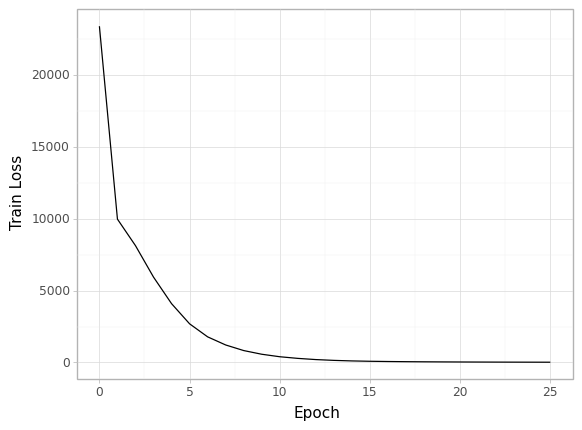

<ggplot: (8739671813928)>

In [29]:
(
    ggplot(train_scores, aes(x='Epoch', y='Train loss'))
        + geom_line(color='black') # line plot
        + labs(x='Epoch', y='Train Loss')
        + theme_light()
)

In [30]:
valid_scores = pd.DataFrame(np.hstack([(range(0, cfg.epochs+1, cfg.check_epoch), total_logs[score], [score for i in range(0, cfg.epochs+1, cfg.check_epoch)]) for score in ['Valid Recall@25', 'Valid NDCG@25', 'Valid Coverage', 'Valid Score']])).T
valid_scores.columns = ['Epoch', 'Score', 'Metric']
valid_scores['Epoch'] = valid_scores['Epoch'].astype(int)
valid_scores['Score'] = valid_scores['Score'].astype(float)

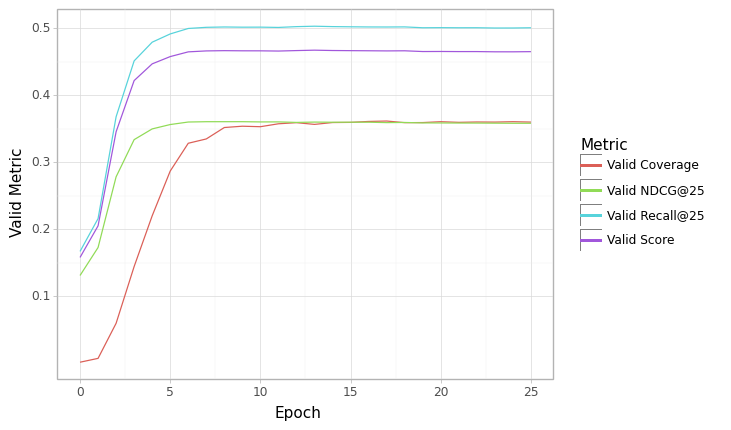

<ggplot: (8739677725169)>

In [31]:
(
ggplot(valid_scores)  # here
    + aes("Epoch", "Score", color='Metric', group='Metric')
    + geom_line()
    + scale_y_continuous(breaks=[0.1*c for c in range(1, 10, 1)])
    + theme_light()
    + labs(x='Epoch', y='Valid Metric')
)  

In [32]:
model.load_state_dict(torch.load(os.path.join(saved_path, 'model(best_scores).pth')))

<All keys matched successfully>

In [34]:
submission_path = os.path.join(data_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission = valid_epoch(cfg, model, submission, mode='test')

100%|██████████████████████████████████████| 8311/8311 [00:35<00:00, 232.14it/s]


In [35]:
submission.to_csv(os.path.join(output_path, 'submission_1.csv'), index = False)